In [1]:
%load_ext autoreload

%autoreload 2

%load_ext snakeviz
import yaml
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.stats import chi2
import multiprocessing as mp

from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing

from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import lin_cost
from ruspy.estimation.estimation_cost_parameters import cost_func
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix

from ruspy.simulation.simulation import simulate
from ruspy.simulation.robust_sim import get_worst_trans

from ruspy.plotting.value_zero import discount_utility
from ruspy.plotting.value_zero import calc_ev_0

In [10]:
# Prepare the raw data.
data_reading()

# Theoretic Framework

In every month (from now on called period) the agent, Harold Zurcher, has the choice to either replace ($i_t = 1$) or to maintain ($i_t = 0$) a bus. The agent chooses his action with the aim to maximize the current value of the bus (Bellman equation):

  \begin{equation}
    V_{\theta}(x_t, \epsilon_t) = \max_{i_t \in \{0, 1\}} [ u(x_t, i_t, \theta) + \epsilon_t (i_t) + \beta EV_{ \theta }( x_t, \epsilon_t, i_t) ]
  \end{equation}
with
  \begin{equation}
  u(x_t,i_t, \theta)=
  \begin{cases}
  -c(x_t, \theta_1) \qquad \qquad \textbf{if} \quad i_t=0 \\
  -[RC + c(0, \theta_1)]\qquad \textbf{if} \quad  i_t=1
  \end{cases}
  \end{equation}

  and Rust shows that $EV_{\theta}(x_t)$ is the fixed point of the following contraction mapping:
<br/>
<br/>
\begin{equation}
  EV_{\theta}(x_t) = \sum_{j \in \{1, 2, 3\}} p_j * \ln\{ \sum_{i_t \in \{0, 1\}} \exp[u(x_t, i_t, \theta_1, RC) + \beta EV_{\theta}(i_t * (x_t + j))]\}
\end{equation}

where
$x_t$ : Mileage on the odometer of the bus in period $t$<br/>
$\varepsilon_t$ : Unobserved information for each decision in period $t$<br/>
$\mathbf{EV}_{\theta}$ : Future expected value of each decision<br/>

and $\theta = \left(\theta_1, \theta_2, \theta_3, \mathbf{RC}, \beta \right)$ is the vector of the unknown variables to be estimated.<br/>

$\theta_1$ : Cost parameter<br/>
$\theta_2$ & $\theta_3$ : Factors that determines the transition probabilities<br/>
$\mathbf{RC}$: Replacement costs of a bus engine<br/>
$\beta$ : Discount factor<br/>


In [13]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 200 buses should be enough to gurantee convergence.
num_buses = 200
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 80000

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize)

#Initilize a dictionary with values needed on the way.
init_dict = {
    'estimation':{
        'groups': 'group_4',
        'beta': beta,
        'maint_func': 'linear',
        'binsize': 5000,
        'states': 90,
    },
    'simulation':{
        'beta': beta,
        'periods': num_periods,
        'seed': 123,
        'maint_func': 'linear',
        'buses': num_buses
    }
    
}
np.random.seed(init_dict['simulation']['seed'])

In [12]:
repl_data_org = data_processing(init_dict['estimation'])

In [15]:
%snakeviz estimate(init_dict['estimation'], repl_data_org)

9998631
9998631
9998631
9998793
9998793
9998793
9998656
9998656
9998656
9998655
9998655
9998655
9998654
9998654
9998654
9998653
9998653
9998653
9998608
9998608
9998608
9998609
9998609
9998609
9998610
9998610
9998610
9998611
9998611
9998611
9998611
9998611
9998611
9998611
9998611
9998611
 
*** Profile stats marshalled to file '/tmp/tmpv3f1sb_p'. 


In [8]:
repl_data_org = data_processing(init_dict['estimation'])
trans_results_org, cost_results_org = estimate(init_dict['estimation'], repl_data_org)
print(trans_results_org, cost_results_org)

{'x': array([0.39189189, 0.59529357, 0.01281454]), 'fun': 3140.5705570938244, 'trans_count': [1682, 2555, 55]}       fun: 163.58583965846046
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13686838e-05, 2.55795385e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([10.07780306,  2.29417033])


In [9]:
# I initialize the the init_dict for the simulation with the estimated parameters.
init_dict['simulation']['known trans'] = trans_results_org['x']
init_dict['simulation']['params'] = cost_results_org['x']

In [10]:
num_states = 200
costs_org = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
trans_probs_org = np.array(init_dict['simulation']['known trans'])
trans_mat_org = create_transition_matrix(num_states, trans_probs_org)

In [31]:
# Simulate a dataset with these values.
df_fig_1, unobs_fig_1, utilities_fig_1, num_states = simulate(init_dict['simulation'])

# The theoretic value at time zero is computed.
costs_org = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
trans_probs_org = np.array(init_dict['simulation']['known trans'])
trans_mat_org = create_transition_matrix(num_states, trans_probs_org)
ev_org = calc_fixp(num_states, trans_mat_org, costs_org, beta)

# Calculate the expected value at time zero
v_exp_fig_1 = np.full(num_points, calc_ev_0(ev_org, unobs_fig_1, num_buses))
# Calculate the value at time 0 by discounting the utility
v_disc_fig_1 = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities_fig_1, beta)
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods, gridsize)

In [32]:
df_fig_1

,state,decision,Bus_ID,period
0,0,0,1,0
1,1,0,1,1
2,2,0,1,2
3,3,0,1,3
4,4,0,1,4
5,5,0,1,5
6,5,0,1,6
7,5,0,1,7
8,6,0,1,8
9,7,0,1,9


[]

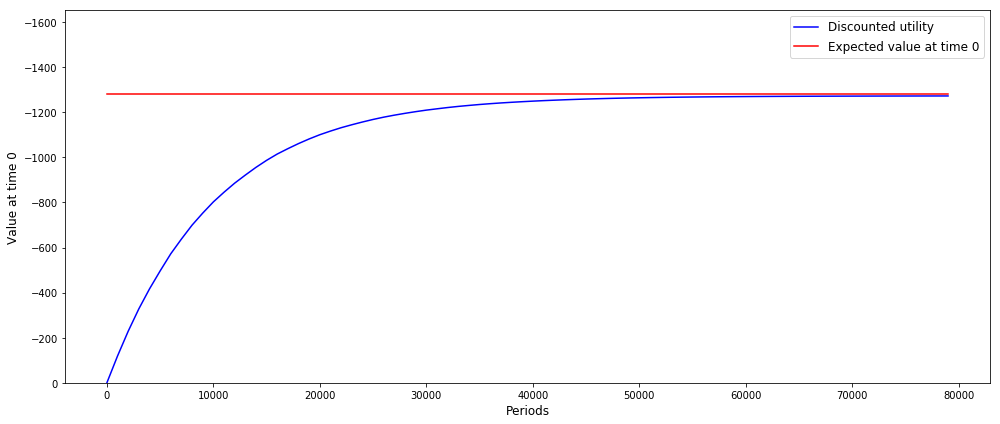

In [7]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1.3 * v_disc_fig_1[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=12)
ax.set_xlabel(r"Periods", fontsize=12)
ax.plot(periods, v_disc_fig_1, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_fig_1, color='red', label='Expected value at time 0')



plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()


# Uncertainty

Now we want to introduce uncertain transition probabilites. For convinience I will not use $\theta_2$ and $\theta_3$ to describe the transition probabilites anymore and instead use the probability meas p directly. Let <br/> <br/>

$\tilde{p_s}$ be the true underlying transition probability. <br/>
$\hat{p_s}$ the maximum liklehood estimate for the transition probabilities. <br/>
$\rho$ the size if the uncertainty set <br/>
$\omega$ the confidence level. <br/>
S the number of states to which a transition is possible. <br/>
$N_s$ the number of observations for state s. <br/>
F the cdf of a chi-squared distribution.<br/>

We model uncertainty as a game between the agent and nature. For now we look at a fixed uncertainty set, but notationwise I distinguish between different sets for each state. The true underlying transition probability lies with $\omega$ in the uncertainty set $P_s$:

$$ \omega = P\{ \tilde{p_s} \in P_s \} = P\{ \tilde{p} \in \{ p : D(p||\hat{p_s}) \leq \rho \} \approx P\{ \chi^2_{|S| - 1} \leq 2N_s\rho \} = F_{|S| - 1}(2N_s\rho )$$
So 
$$\rho = F_{|S| - 1}^{-1}(\omega)/2N_s$$

So if x_t is s:

  \begin{equation}
    V_{\theta}(x_t, \epsilon_t) = \min_{p \in P_{x_t=s}} \max_{i_t \in \{0, 1\}} [ u(x_t, i_t, \theta) + \epsilon_t (i_t) + \beta EV_{ \theta, p }( x_t, \epsilon_t, i_t) ]
  \end{equation}

So for the following exploration I will choose an uncertainty set and therefore worst case probabilites in state 0 and let those be fixed. In the end I will look at decision strategies, where the agent anticipates a misestimation and therefore chooses a size of his own uncertainty set and then acts as the worst case transition probability of these sets were the true ones.

As Rust doesn't estimate the transition probabilities for each state, that's the first modification I will need to do. The second is, that Rust took a weird convention or I didn't fully understand the his model yet: <br/>
Whenever a engine is replaced, he counts transition afterwards as an increase by one. In the following code cell, I estimate the model with the (for me intiutive) rule: <br/>
If an engine is replaced, I look at the following state, if that is 0,1 or 2. Also I implemented a counting function for the observations in each state.



In [14]:
trans_results_5000, state_count_5000, cost_results_5000 = estimate(init_dict['estimation'], repl_data_org, repl_4=False)
print(trans_results_5000['x'], cost_results_5000['x'])
print(trans_results_org['x'], cost_results_org['x'])

[0.39958063 0.58760479 0.01281458] [10.08896882  2.28097345]
[0.39189477 0.59529015 0.01281509] [10.07776827  2.29415225]


In [17]:
trans_mat = state_count_5000 / state_count_5000.sum(axis=1)[:, np.newaxis]
trans_mat[4]

array([0.        , 0.        , 0.        , 0.        , 0.46218487,
       0.52941176, 0.00840336, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [18]:
# As Rust pools all observations, there is not a big space for uncertainty. Therefore the size of the uncertainty set for state 0
# and a confidence of 95% calculated by the the expression above is very small:
roh = chi2.ppf(0.95, len(trans_results_5000['x']) - 1) / (2 * sum(state_count_5000[0]))
roh

0.017518902184526255

In [19]:
# Therefore we set the size of the uncertainty set for now to 2.5:
roh = 2.5 
roh

2.5

In [20]:
# We seen above, that with the new estimation method, the paramters deviate not substantial from the "real" ones.
# I initialize the new values and roh now in the init_dict
init_dict['simulation']['known trans'] = trans_results_5000['x']
init_dict['simulation']['params'] = cost_results_5000['x']
# The worst case probabilites are calculated for a space size of 90 states.
num_states = 90
worst_trans_5000 = get_worst_trans(init_dict['simulation'], roh, num_states, max_it=1000)
init_dict['simulation']['real trans'] = worst_trans_5000

In [41]:
df_fig_1.state.max()

134

In [21]:
# This state space is enough and by setting it manually at lot of time is saved
num_states = 250
# The cost vector for the new parameters
costs_5000 = cost_func(num_states, lin_cost, init_dict['simulation']['params'])

# The known transition probabilites, allow as to evaluate ev_known. I programmed an option in the simualte function, 
# which saves a lot of time with the pre known ev_known.
known_trans_probs_5000 = np.array(init_dict['simulation']['known trans'])
known_trans_mat_5000 = create_transition_matrix(num_states, known_trans_probs_5000)
ev_known_5000 = calc_fixp(num_states, known_trans_mat_5000, costs_5000, beta)
init_dict['simulation']['ev_known'] = ev_known_5000

# For consistensy I use the same state space for the real ones.
real_trans_probs_5000 = np.array(init_dict['simulation']['real trans'])
real_trans_mat_5000 = create_transition_matrix(num_states, real_trans_probs_5000)
ev_real_5000 = calc_fixp(num_states, real_trans_mat_5000, costs_5000, beta)

# So with the worst case probabilites as the real ones, I calculate the new strategy
df_5000, unobs_5000, utilities_5000, num_states = simulate(init_dict['simulation'])

In [23]:
# The arrays for plotting
v_exp_real_5000 = np.full(num_points, calc_ev_0(ev_real_5000, unobs_5000, num_buses))
v_exp_known_5000 = np.full(num_points, calc_ev_0(ev_known_5000, unobs_5000, num_buses))

# The discounted utility of the decision strategy
v_disc_5000 = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities_5000, beta)

[]

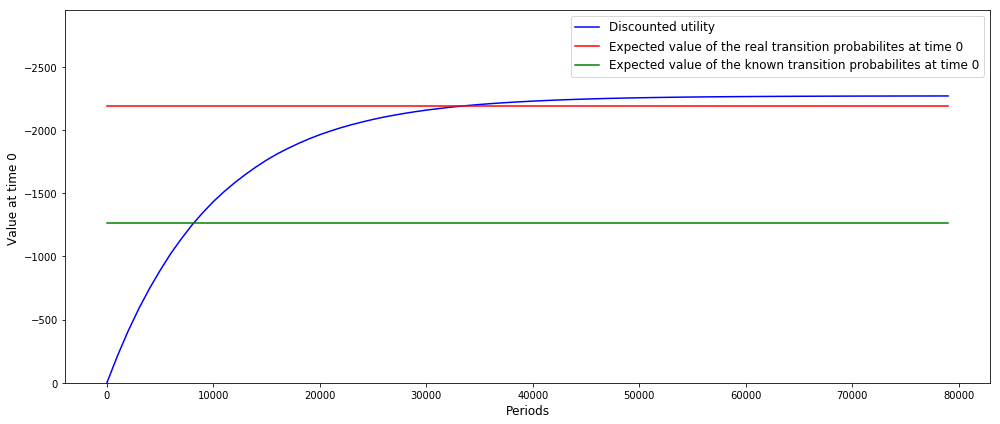

In [24]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0, 1.3 * v_disc_5000[-1]])

ax.set_ylabel(r"Value at time 0 ", fontsize=12)
ax.set_xlabel(r"Periods", fontsize=12)

ax.plot(periods, v_disc_5000, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_real_5000, color='red', label='Expected value of the real transition probabilites at time 0')
ax.plot(periods, v_exp_known_5000, color='green',label='Expected value of the known transition probabilites at time 0')

plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

In [25]:
for i in range(len(real_trans_probs_5000)):
    print(np.round(real_trans_probs_5000[i], 4), np.round(known_trans_probs_5000[i], 4), i)
print(v_disc_5000[-1] / v_exp_real_5000[0])

0.002 0.3996 0
0.3169 0.5876 1
0.6811 0.0128 2
1.0376040991124107


If we look at the real transition probabilities compared to the ones known to the agent, there is a big shift towards the highest reachable state. The uncertainty set size of 2.5 is very large compared to the "real" one. The resulting loss due to information, so the gap between the blue and red line, is only 3,75 % though. The power of this method therefore needs a better setting. I will now discretisize the state space a lot finer and explore how the higher degree of freedom influences the performance gap.

### Finer state space and performance of different strategies

In [26]:
# So now choose 1000 miles as binsize and estimate the model.
init_dict['estimation']['binsize'] = 1000
init_dict['estimation']['states'] = 450
init_dict['estimation']['max_it'] = 1000
repl_data = data_processing(init_dict['estimation'])
trans_results, state_count, cost_results = estimate(init_dict['estimation'], repl_data, repl_4=False)
print(trans_results, cost_results)

     fun: 7581.755519011549
     jac: array([-4291.98876953, -4292.00909424, -4292.01550293, -4291.99017334,
       -4292.00201416, -4291.99639893, -4292.00158691, -4291.63916016,
       -4290.96063232, -4292.23297119, -4291.89801025, -4290.65582275,
       -4290.68988037])
 message: 'Optimization terminated successfully.'
    nfev: 1336
     nit: 75
    njev: 75
  status: 0
 success: True
       x: array([2.86580358e-02, 8.10809022e-02, 2.79122939e-01, 2.46039699e-01,
       1.81733365e-01, 1.30242414e-01, 4.65982979e-02, 3.72817179e-03,
       4.66088648e-04, 6.98929448e-04, 9.31981148e-04, 4.66121756e-04,
       2.33055301e-04])       fun: 163.71080283705228
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.00012221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 11
   status: 0
  success: True
        x: array([10.13297317,  0.45596175])


In [27]:
# Initialize the new init_dict
init_dict['simulation']['known trans'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']

In [28]:
# The cost vector for the new parameters
num_states = 1000
costs = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
known_trans_probs = np.array(init_dict['simulation']['known trans'])
known_trans_mat = create_transition_matrix(num_states, known_trans_probs)
ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
# I programmed an option in the simulate function for a pre known EV. As NFXP is the computational bottleneck,
# this makes the function a lot faster.
init_dict['simulation']['ev_known'] = ev_known

In [29]:
# The worst case probabilites are calculated for a space size of 250. This is due to computational reasons, as explained below.
num_states = 250 # A larger state size would take a lot more time. But the EV(0) converges with a state space of ca. 800
roh = 2.5
worst_trans = get_worst_trans(init_dict['simulation'], roh, num_states, max_it=1000) # Same speed issue for iterrations
init_dict['simulation']['real trans'] = worst_trans

In [30]:
df, unobs, utilities, num_states = simulate(init_dict['simulation'])

In [31]:
# For a better understanding, I use real_trans_probs instead of worst_case in the following
real_trans_probs = np.array(init_dict['simulation']['real trans'])
real_trans_mat = create_transition_matrix(num_states, real_trans_probs)

In [32]:
# The value of the real expected utility
ev_real = calc_fixp(num_states, real_trans_mat, costs, beta)

[]

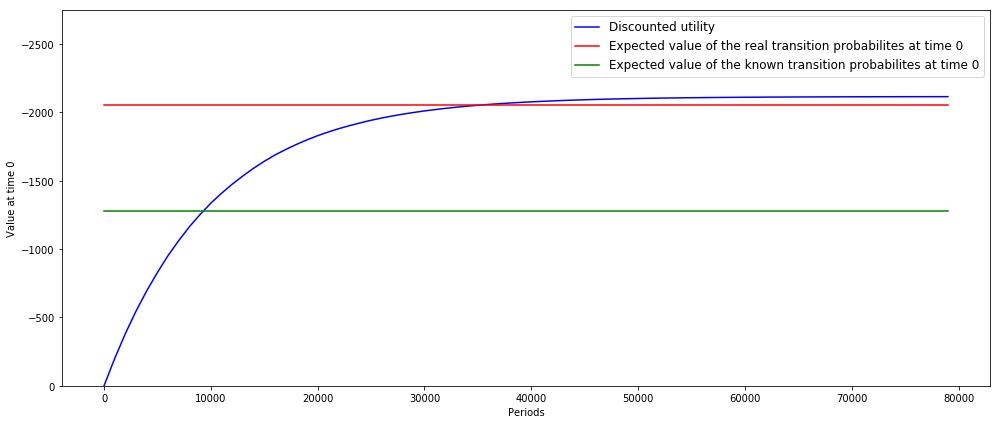

In [33]:
# The discounted utility of the decision strategy
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)

# The arrays for plotting
v_exp_known = np.full(num_points, calc_ev_0(ev_known, unobs, num_buses))
v_exp_real = np.full(num_points, calc_ev_0(ev_real, unobs, num_buses))
periods = np.arange(0, num_periods, gridsize)


fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0, 1.3 * v_disc[-1]])

ax.set_ylabel(r"Value at time 0")
ax.set_xlabel(r"Periods")

ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_real, color='red', label='Expected value of the real transition probabilites at time 0')
ax.plot(periods, v_exp_known, color='green',label='Expected value of the known transition probabilites at time 0')

plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()


plt.plot()

In [34]:
for i in range(len(real_trans_probs)):
    print(np.round(real_trans_probs[i], 4), np.round(known_trans_probs[i], 4), i)
print(v_disc[-1] / v_exp_real[0])

0.0004 0.0287 0
0.003 0.0811 1
0.0257 0.2791 2
0.0568 0.246 3
0.1043 0.1817 4
0.1844 0.1302 5
0.1616 0.0466 6
0.0315 0.0037 7
0.0096 0.0005 8
0.0342 0.0007 9
0.1086 0.0009 10
0.1287 0.0005 11
0.1513 0.0002 12
1.0283241691424152


In [35]:
roh = chi2.ppf(0.95, len(trans_results['x']) - 1) / (2 * sum(state_count[0]))
roh

0.14401417683207582

## Performance with different uncertainty set sizes

Here the "real" of the uncertainty set is about a factor 10 higher. The loss due to misinformation is only 2,83 % and therefore by a third smaller. I will now look at different uncertainty set sizes and evaluate how the agent performs with his misbelief about the transition probabilities.

In [56]:
if 'ev_known' in init_dict['simulation'].keys():
    del init_dict['simulation']['ev_known']
if 'real trans' in init_dict['simulation'].keys():
    del init_dict['simulation']['real trans']
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 1000,
  'states': 450,
  'max_it': 1000},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 200,
  'known trans': array([2.86580358e-02, 8.10809022e-02, 2.79122939e-01, 2.46039699e-01,
         1.81733365e-01, 1.30242414e-01, 4.65982979e-02, 3.72817179e-03,
         4.66088648e-04, 6.98929448e-04, 9.31981148e-04, 4.66121756e-04,
         2.33055301e-04]),
  'params': array([10.13297317,  0.45596175])}}

In [57]:
# For the plot I want to evaluate the following values of roh
roh_plot = np.append(np.arange(0, 0.8, 0.1), np.arange(0.8, 8, 0.2))
roh_plot

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1. , 1.2, 1.4, 1.6,
       1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2,
       4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8,
       7. , 7.2, 7.4, 7.6, 7.8])

In [58]:
def worst_trans(roh):
    num_states = 200 # Again for speed issues
    return get_worst_trans(init_dict['simulation'], roh, num_states, max_it=1000)

In [59]:
# I first want a list of worst case transition probabilites for different uncertainty set sizes.
# pool = mp.Pool(7)
# all_worst_trans = pool.map(worst_trans, roh_plot)
# np.savetxt('worst_trans.txt')
all_worst_trans = np.loadtxt('worst_trans.txt')

In [60]:
def evaluate_strategies(real):
    init_dict_real = copy.deepcopy(init_dict['simulation'])
    init_dict_real['real trans'] = real
    df, unobs, utilities, num_states = simulate(init_dict_real)
    v_disc = discount_utility([0., 0.], num_buses, num_periods, num_periods, utilities, beta)
    return v_disc[-1]

In [61]:
# In the first strategy the agent has the ml estimate as his known transition probability.
# num_states = 1200
# costs = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
# init_dict['simulation']['known trans'] = known_trans_probs
# known_trans_mat = create_transition_matrix(num_states, init_dict['simulation']['known trans'])
# ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
# init_dict['simulation']['ev_known'] = ev_known
# pool = mp.Pool(7)
# ml_strategy = pool.map(evaluate_strategies, all_worst_trans)
ml_strategy = np.loadtxt('ml_strategy.txt')

In [63]:
# In the second strategy the agent has the worst case transition probability of a n uncertainty set size
# of 1 as his known transition probability.
# num_states = 1200
# costs = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
# init_dict['simulation']['known trans'] = all_worst_trans[9]
# known_trans_mat = create_transition_matrix(num_states, init_dict['simulation']['known trans'])
# ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
# init_dict['simulation']['ev_known'] = ev_known
# pool = mp.Pool(7)
# roh_1_strategy = pool.map(evaluate_strategies, all_worst_trans)
roh_1_strategy = np.loadtxt('roh_1_strategy.txt')

In [65]:
# In the third strategy the agent as the worst case transition probability of an uncertainty set size
# of 3 as his known transition probability.
# num_states = 1200
# costs = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
# init_dict['simulation']['known trans'] = all_worst_trans[19]
# known_trans_mat = create_transition_matrix(num_states, init_dict['simulation']['known trans'])
# ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
# init_dict['simulation']['ev_known'] = ev_known
# pool = mp.Pool(6)
# roh_3_strategy = pool.map(evaluate_strategies, all_worst_trans)
roh_3_strategy = np.loadtxt('roh_3_strategy.txt')

In [78]:
def trans_to_fixp(real):
    trans_mat = create_transition_matrix(num_states, real)
    fixp = calc_fixp(num_states, trans_mat, costs, beta)
    print(fixp[0])
    return fixp[0]

In [ ]:
# The optimal strategy is just the expected value at time 0 for all transition probabilities.
num_states = 1200
costs = cost_func(num_states, lin_cost, init_dict['simulation']['params'])
pool = mp.Pool(6)
opt_strategy = pool.map(trans_to_fixp, all_worst_trans)

[]

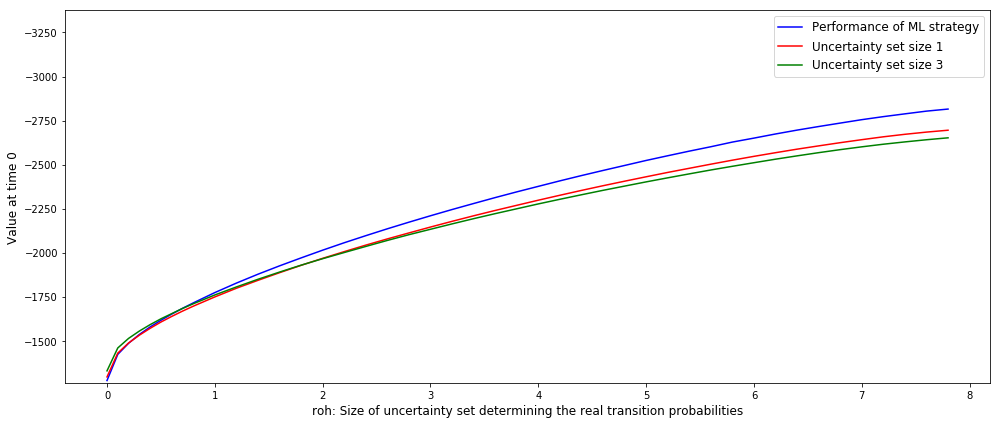

In [80]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0.99 * ml_strategy[0], 1.2 * ml_strategy[-1]])

ax.set_ylabel(r"Value at time 0", fontsize=12)
ax.set_xlabel(r"roh: Size of uncertainty set determining the real transition probabilities", fontsize=12)

ax.plot(roh_plot, ml_strategy, color='blue', label='Performance of ML strategy')
ax.plot(roh_plot, roh_1_strategy, color='red', label='Uncertainty set size 1')
ax.plot(roh_plot, roh_3_strategy, color='green', label='Uncertainty set size 3')
#ax.plot(roh_plot, opt_strategy, color='yellow', label='Optimal strategy')

plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()


plt.plot()

My main problem, which remains to be solved is:

If I want to make the power of this method visible, I have to look at finer discretezation and therefore at higher possible increase of states per period. A higher possible increase results in a larger state space, which drives up the conmputational time of the NFXP dramatically.

Second main problem:
No spell checker in jupyter lab!